In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 100
m = 100
num_itr = 30
K = 500
adam_lr = 5e-4
max_inner = 40
noise_std = 3.0

A = jnp.array(np.random.randn(m, n))
eig, _ = LA.eig(A.T@A)
lambda_max = max(eig)
eta_opt = 1/lambda_max

In [3]:
@jax.jit
def gen_y(x):
    y = A@x + noise_std * jnp.array(np.random.randn(m, 1))
    return y
batch_gen_y = jax.vmap(gen_y, in_axes=-1, out_axes=-1)

In [4]:
xs = np.linspace(-5, 5, 500)

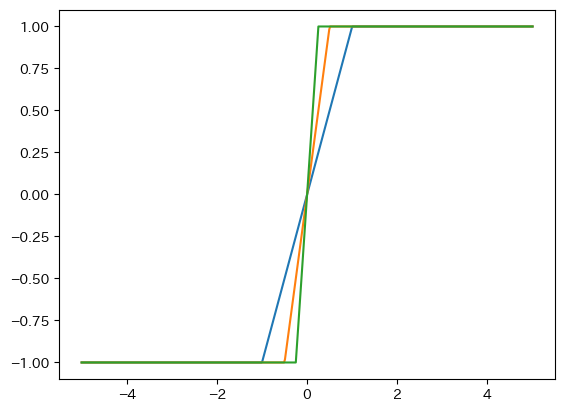

In [5]:
plt.figure()
plt.plot(xs, jax.nn.hard_tanh(xs))
plt.plot(xs, jax.nn.hard_tanh(2*xs))
plt.plot(xs, jax.nn.hard_tanh(4*xs));

In [6]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [7]:
# @partial(jax.jit, static_argnums=[0,2])
def ProjectedGD(max_itr, y, func):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x -= eta_opt* A.T @ (A@x - y)
        x = jnp.array(list(map(func, x)))
    return x

def comp_mse(max_itr, func):
    x_org = jnp.ones((n, K)) - 2.0 * jnp.array(np.random.binomial(1,0.5,size=(n, K)))
    y = batch_gen_y(x_org)
    x_hat = ProjectedGD(max_itr, y, func)
    return np.sum(batch_get_dot(x_org - x_hat))/K

In [8]:
df = pd.DataFrame()
df["Iteration"] = range(num_itr)

In [9]:
GD_mse1 = [float(comp_mse(i+1, jax.nn.hard_tanh)) for i in range(num_itr)]

In [10]:
df["PGD(hardtanh)"] = GD_mse1

In [11]:
GD_mse2 = [float(comp_mse(i+1, jnp.sign)) for i in range(num_itr)]

In [12]:
df["PGD(sign)"] = GD_mse2

In [13]:
def DU_ProjectedGD(max_itr, y, eta, alpha):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta[i] * A.T @ (A@x - y)
        x = jax.nn.hard_tanh(alpha[i] * x)
    return x

In [14]:
def loss(x_opt, max_itr, y, eta, alpha):
    x_hat = DU_ProjectedGD(max_itr, y, eta, alpha)
    return jnp.sum(batch_get_dot(x_opt - x_hat))/K

In [15]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)

def step(x_opt, max_itr, y, step_num, opt_state1, opt_state2):
    tmp_eta = get_params1(opt_state1)
    tmp_alpha = get_params2(opt_state2)
    value, grads = jax.value_and_grad(loss, argnums=-2)(x_opt, max_itr, y, tmp_eta, tmp_alpha)
    new_opt_state1 = opt_update1(step_num, grads, opt_state1)
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_opt, max_itr, y, tmp_eta, tmp_alpha)
    new_opt_state2 = opt_update2(step_num, grads, opt_state2)
    return value, new_opt_state1, new_opt_state2

def train(eta, alpha):
    opt_state1 = opt_init1(eta)
    opt_state2 = opt_init2(alpha)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            x_opt = jnp.ones((n, K)) - 2.0 * jnp.array(np.random.binomial(1,0.5,size=(n, K)))
            y = batch_gen_y(x_opt)
            value, opt_state1, opt_state2 = step(x_opt, itr+1, y, i, opt_state1, opt_state2)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [19]:
def comp_mse_DUGD(max_itr, eta, alpha):
    x_org = jnp.ones((n, K)) - 2.0 * jnp.array(np.random.binomial(1,0.5,size=(n, K)))
    y = batch_gen_y(x_org)
    return loss(x_org, max_itr, y, eta, alpha)

In [17]:
# 手元のPCのスペックの都合でnum_itrを調整
num_itr = 15
eta_init = jnp.zeros(num_itr)
alpha_init = jnp.ones(num_itr)
eta_trained, alpha_trained = train(eta_init, alpha_init)

  0%|          | 0/15 [00:00<?, ?it/s]

loss:20097.96484375  

In [20]:
DUGD_mse = [float(comp_mse_DUGD(i+1, eta_trained, alpha_trained)) for i in range(num_itr)]
df2 = pd.DataFrame()
df2["Iteration"] = range(num_itr)
df2["DU-PGD"] = DUGD_mse

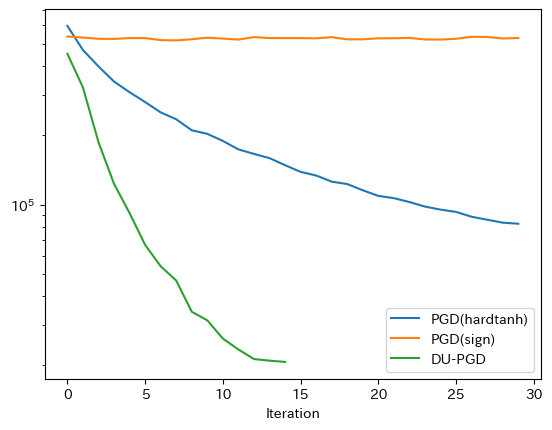

In [22]:
ax = df.plot(df.columns[0], df.columns[1:])
df2.plot("Iteration", "DU-PGD", ax=ax)
plt.yscale("log")

In [24]:
df2["eta"] = eta_trained
df2["alpha"] = alpha_trained

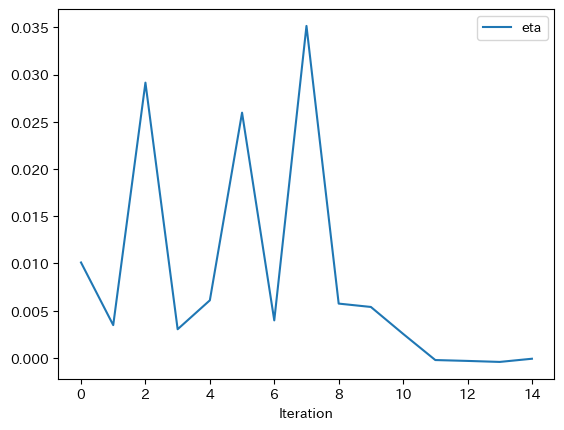

In [26]:
df2.plot("Iteration", "eta");

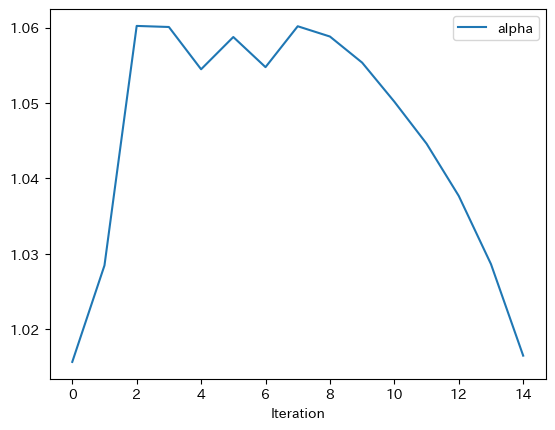

In [27]:
df2.plot("Iteration", "alpha");